In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

import h5py
import time


#import matplotlib.colors as mcolors
#from matplotlib import rcParams

#import os
#-----


# Enable interactive plot
#%matplotlib notebook
#plt.style.use('pusheen')  # to poster
%config InlineBackend.figure_format = 'retina'  # for high resolution
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

#color1 = ['#ff595e','#ffca3a','#8ac926','#1982c4','#6a4c93']
#color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

# Loading dataset 🗃️ 

In [2]:
delta = True # True: y_pred = Psi_t -Psi_{t-1}; else: y_pred = Psi_t 

if delta == True:
    path_dat = '../data/DataNew/datadeltav2.h5'
else:
    path_dat = '../dataLoader/Data/data.h5'

In [3]:
# New dataset class
class Propagator_Dataset(Dataset):
    
    def __init__(self, path, data, targets, stats=None, transform=True):
        """
        path: path to HDF5 file
        data: dataset name for inputs (X)
        targets: dataset name for labels (y)
        stats: dictionary with normalization stats, e.g. {"X": {"mean": ..., "std": ...}, "y": {...}}
        transform: if True, converts to torch.tensor
        """
        self.data = data
        self.targets = targets
        self.stats = stats
        self.transform = transform
        self.hf = h5py.File(path, 'r')  # keep file handle open
    
    def __getitem__(self, index):
        X = self.hf.get(self.data)[index]
        y = self.hf.get(self.targets)[index]
        
        if self.transform:
            X = torch.tensor(X, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)
        
        # normalize if stats provided
        if self.stats is not None:
            if "X" in self.stats:
                mean, std = self.stats["X"]["mean"], self.stats["X"]["std"]
                X = (X - mean) / (std + 1e-8)  # avoid division by 0
            if "y" in self.stats:
                mean, std = self.stats["y"]["mean"], self.stats["y"]["std"]
                y = (y - mean) / (std + 1e-8)
        
        return X, y
    
    def get_seq_len(self):
        return self.hf.get(self.data).shape[1]
    
    def get_num_grid_points(self):
        return self.hf.get(self.data).shape[2] // 3  # assuming input shape (N, seq_len, 3*n_grid)
    
    def __len__(self):
        return len(self.hf.get(self.data))


In [6]:
raw_dataset = Propagator_Dataset(path=path_dat, data='dataset_X', targets='dataset_y')

In [4]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, path, data, targets, transform=True):
        
        self.data = data  # path of data X
        self.targets = targets  # path of labels y
        self.transform = transform  # to tensor
        self.hf = h5py.File(path, 'r')  # reading data
        
        
    def __getitem__(self, index):
        
        X = self.hf.get(self.data)[index]
        y = self.hf.get(self.targets)[index]
        
        if self.transform:
            X = torch.tensor(X)
            y = torch.tensor(y)
        
        return X, y
    
    def get_seq_len(self):
        # seq_len is the number of steps on trajectories
        seq_len = self.hf.get(self.data).shape[1]
        return seq_len
    
    def get_num_grid_points(self):
        num_grid_points = self.hf.get(self.data).shape[2] // 3  # assuming data input is in shape (N, seq_len, 3*n_grid)
        return num_grid_points
    
    def __len__(self):
        tot = len(self.hf.get(self.data))
        return tot

In [5]:
raw_dataset = Propagator_Dataset(path=path_dat, data='dataset_X', targets='dataset_y')

In [7]:
print(f"Dataset length (Number of trajectories): {len(raw_dataset)}")
print(f"Sequence length: {raw_dataset.get_seq_len()}")
print(f"Number of grid points: {raw_dataset.get_num_grid_points()}")

Dataset length (Number of trajectories): 12000
Sequence length: 200
Number of grid points: 32


# Histograms of input 📊

In [8]:
def analyze_dataset(dataset, n_samples=100, per_feature=False):
    """
    Plots histograms and prints stats for X and y.
    
    Args:
        dataset: your Propagator_Dataset object
        n_samples: number of samples to analyze
        per_feature: if True, show psi_real, psi_imag, V, delta_real, delta_imag separately
                     if False, just X vs y
    """
    all_X, all_y = [], []
    X_real, X_imag, V = [], [], []
    d_real, d_imag = [], []
    
    n_samples = min(n_samples, len(dataset))  # avoid out of range
    num_grid_points = dataset.get_num_grid_points()

    for i in range(n_samples):
        X, y = dataset[i]   # X: (seq_len, 3*grid), y: (seq_len, 2*grid)

        all_X.append(X.flatten())
        all_y.append(y.flatten())

        if per_feature:
            X_real.append(X[:, :num_grid_points].flatten())
            X_imag.append(X[:, num_grid_points:2*num_grid_points].flatten())
            V.append(X[:, 2*num_grid_points:].flatten())
            d_real.append(y[:, :num_grid_points].flatten())
            d_imag.append(y[:, num_grid_points:].flatten())

    # Flatten everything
    X_all = torch.cat(all_X).numpy()
    y_all = torch.cat(all_y).numpy()

    # Helper to print stats
    def stats(name, data):
        print(f"{name}: mean={np.mean(data):.4e}, std={np.std(data):.4e}, "
              f"min={np.min(data):.4e}, max={np.max(data):.4e}")

    if not per_feature:
        # --- simple all-in-one mode ---
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))

        axs[0].hist(X_all, bins=100, color='skyblue')
        axs[0].set_title('X distribution')
        axs[0].set_xlabel('Value')

        axs[1].hist(y_all, bins=100, color='salmon')
        axs[1].set_title('y distribution')
        axs[1].set_xlabel('Value')

        plt.tight_layout()
        plt.show()

        stats("X", X_all)
        stats("y", y_all)

    else:
        # --- per feature mode ---
        X_real = torch.cat(X_real).numpy()
        X_imag = torch.cat(X_imag).numpy()
        V      = torch.cat(V).numpy()
        d_real = torch.cat(d_real).numpy()
        d_imag = torch.cat(d_imag).numpy()

        fig, axs = plt.subplots(1, 5, figsize=(20, 4))

        axs[0].hist(X_real, bins=100, color='blue', alpha=0.7)
        axs[0].set_title('Psi_real')

        axs[1].hist(X_imag, bins=100, color='red', alpha=0.7)
        axs[1].set_title('Psi_imag')

        axs[2].hist(V, bins=100, color='green', alpha=0.7)
        axs[2].set_title('Potential V')

        axs[3].hist(d_real, bins=100, color='purple', alpha=0.7)
        axs[3].set_title('Delta Psi_real')

        axs[4].hist(d_imag, bins=100, color='orange', alpha=0.7)
        axs[4].set_title('Delta Psi_imag')

        plt.tight_layout()
        plt.show()

        stats("Psi_real", X_real)
        stats("Psi_imag", X_imag)
        stats("Potential V", V)
        stats("Delta Psi_real", d_real)
        stats("Delta Psi_imag", d_imag)

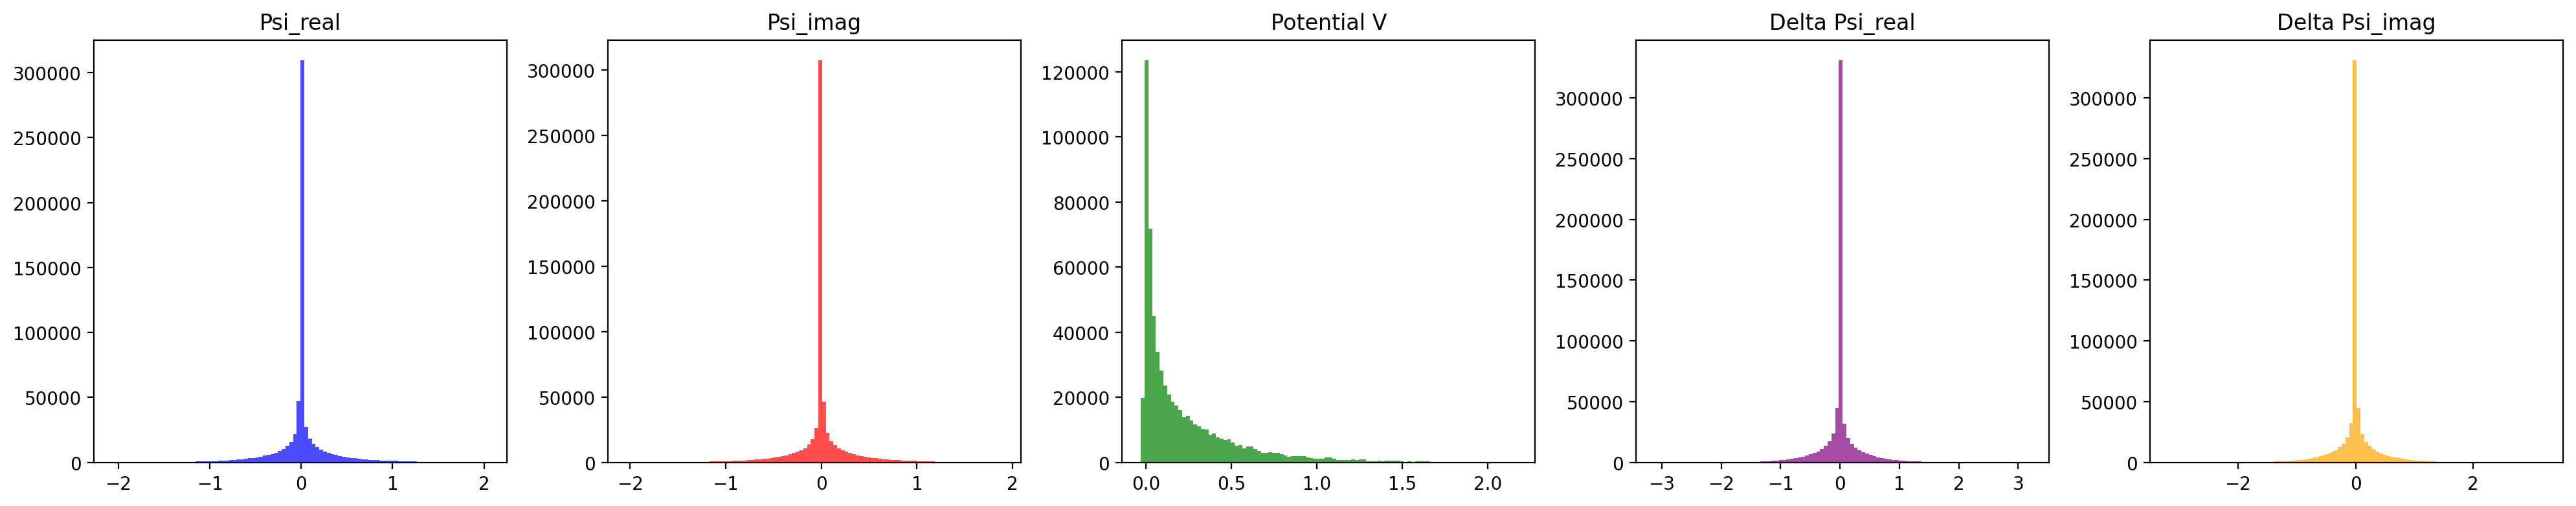

Psi_real: mean=9.7647e-03, std=2.9412e-01, min=-2.0615e+00, max=2.0472e+00
Psi_imag: mean=4.2603e-03, std=2.9027e-01, min=-2.0339e+00, max=1.8924e+00
Potential V: mean=2.2023e-01, std=2.9622e-01, min=-3.1033e-02, max=2.1670e+00
Delta Psi_real: mean=-6.4705e-04, std=3.3432e-01, min=-3.1151e+00, max=3.2052e+00
Delta Psi_imag: mean=-6.9201e-04, std=3.3536e-01, min=-3.1755e+00, max=3.2115e+00


In [9]:
analyze_dataset(raw_dataset, n_samples=100, per_feature=True)

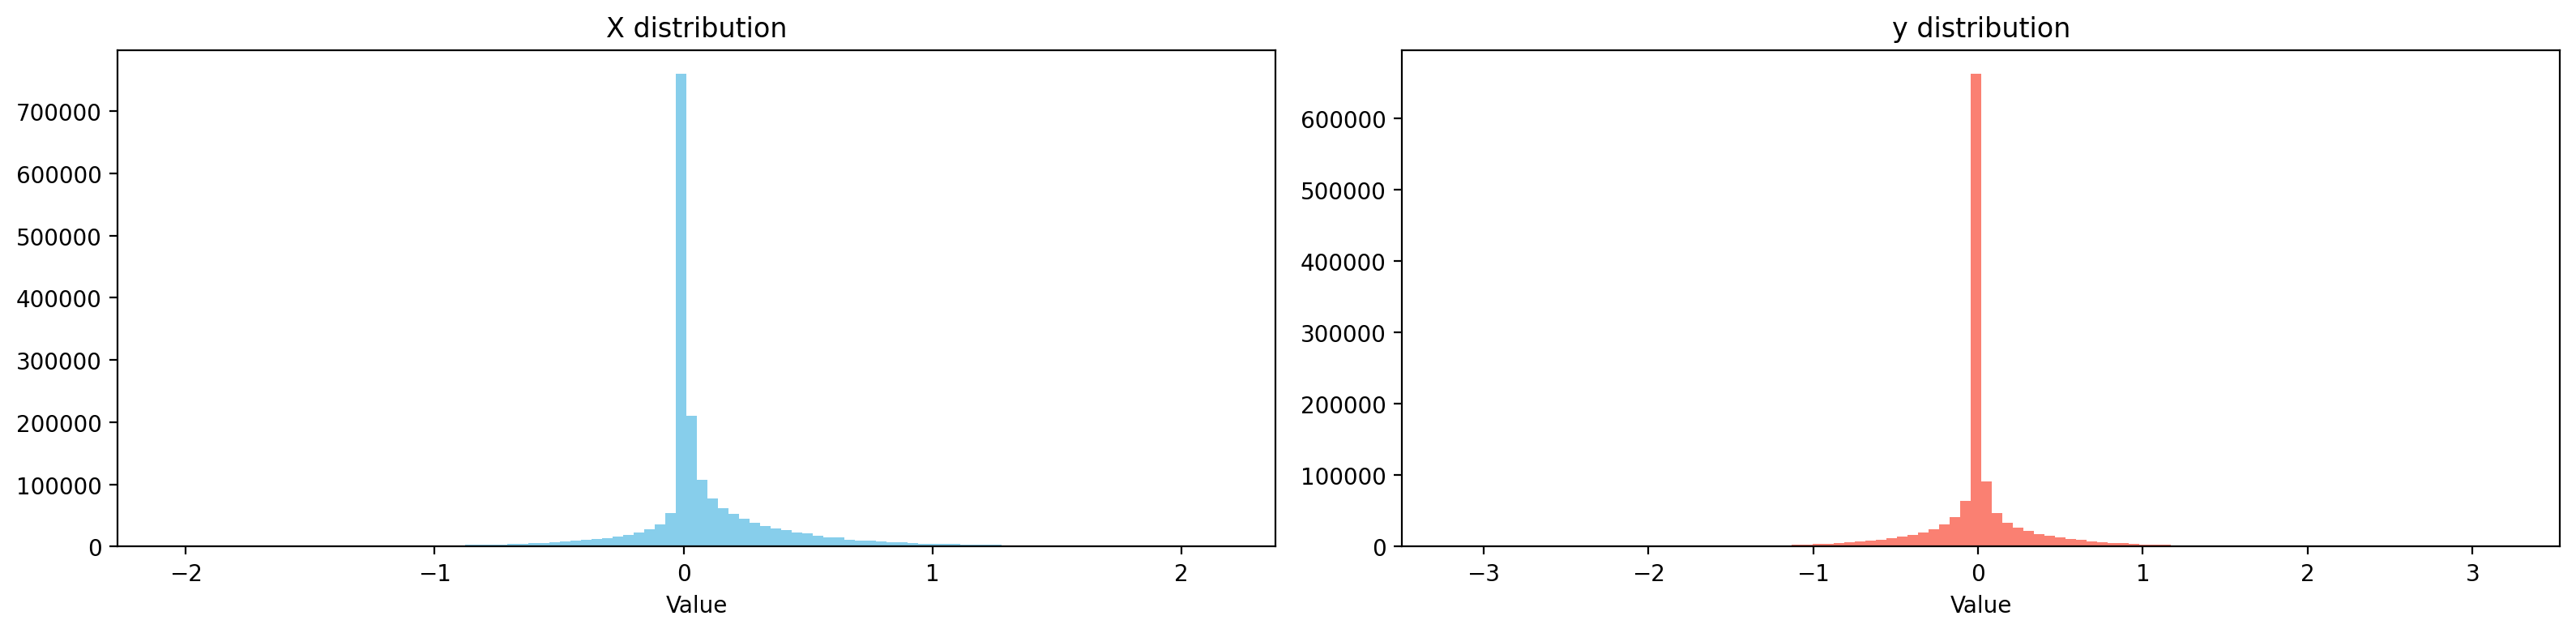

X: mean=7.8085e-02, std=3.1029e-01, min=-2.0615e+00, max=2.1670e+00
y: mean=-6.6953e-04, std=3.3484e-01, min=-3.1755e+00, max=3.2115e+00


In [10]:
analyze_dataset(raw_dataset, n_samples=100, per_feature=False)

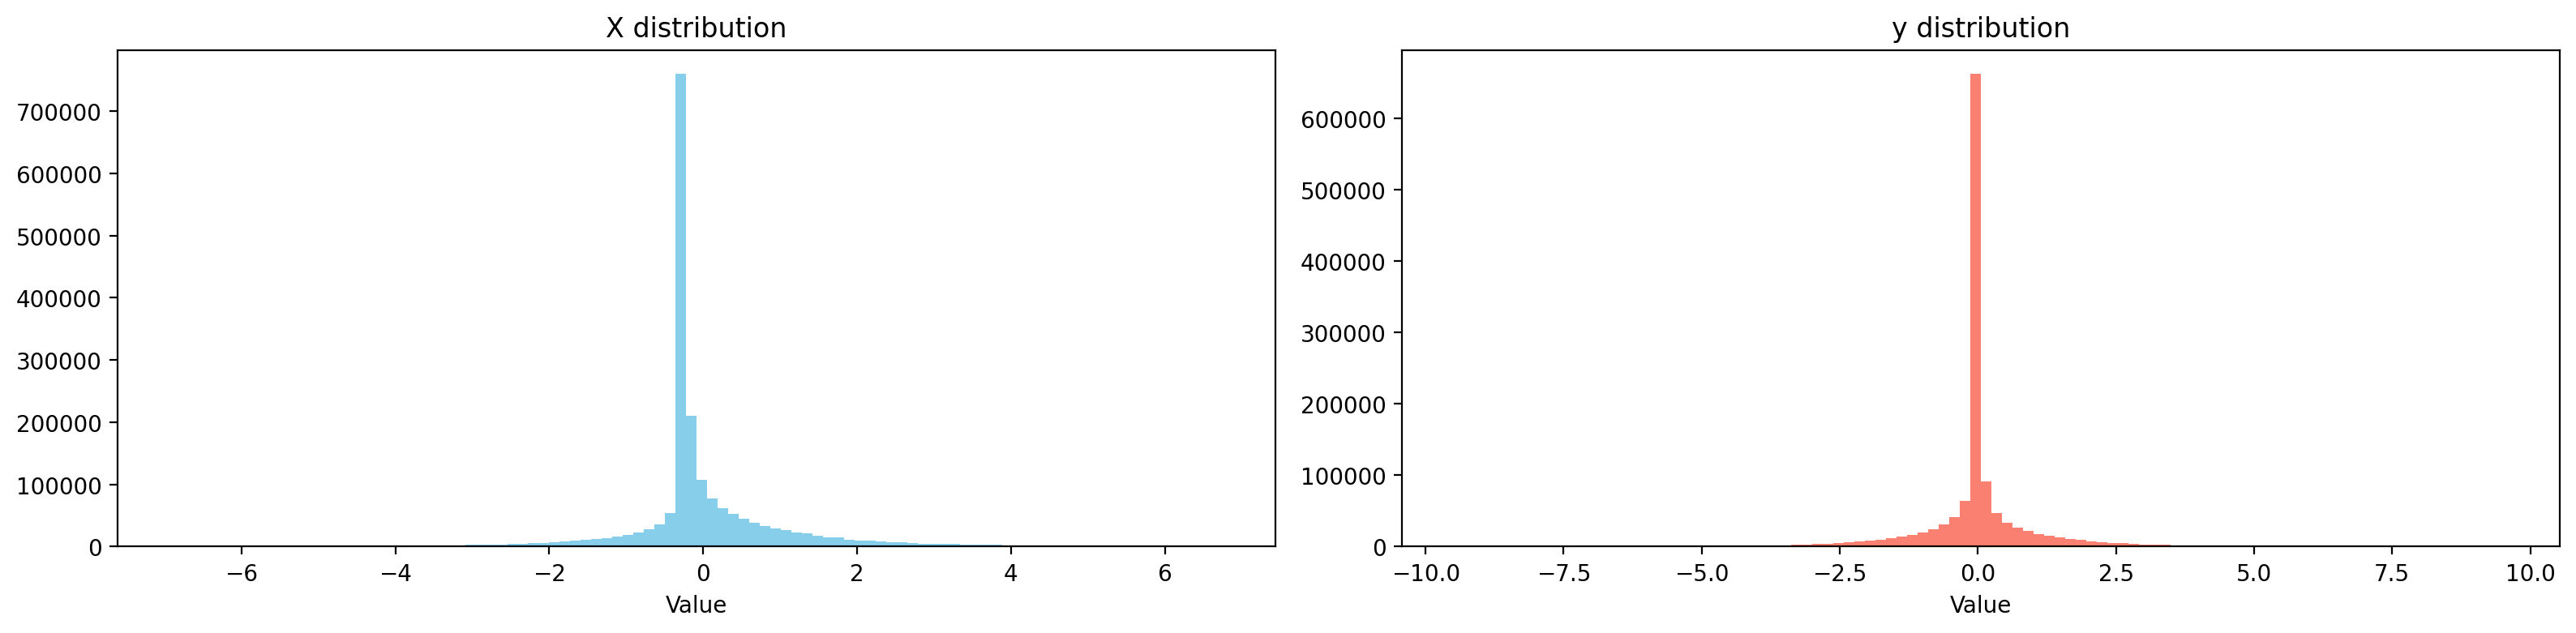

X: mean=-2.5214e-03, std=1.0039e+00, min=-6.9246e+00, max=6.7557e+00
y: mean=-1.0137e-04, std=9.9910e-01, min=-9.4733e+00, max=9.5845e+00


In [14]:
analyze_dataset(normalized_dataset, n_samples=100, per_feature=False)

# Normalizing data 🗂️

## Normalizing all features  
- This means we just calculalte the main and std for the whole features in X and whole features in y.

In [11]:
from torch.utils.data import DataLoader
import torch

def compute_stats(dataset, batch_size=32):
    """
    Compute mean/std for X and y over the dataset (streaming, no memory blowup).
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    sum_X = 0.0
    sum_sq_X = 0.0
    sum_Y = 0.0
    sum_sq_Y = 0.0
    total_X = 0
    total_Y = 0

    for X_batch, Y_batch in loader:
        # flatten across batch & time
        X_flat = X_batch.view(-1)
        Y_flat = Y_batch.view(-1)

        sum_X += X_flat.sum().item()
        sum_sq_X += (X_flat ** 2).sum().item()
        total_X += X_flat.numel()

        sum_Y += Y_flat.sum().item()
        sum_sq_Y += (Y_flat ** 2).sum().item()
        total_Y += Y_flat.numel()

    mean_X = sum_X / total_X
    std_X = (sum_sq_X / total_X - mean_X**2) ** 0.5

    mean_Y = sum_Y / total_Y
    std_Y = (sum_sq_Y / total_Y - mean_Y**2) ** 0.5

    return {
        "X": {"mean": mean_X, "std": std_X},
        "y": {"mean": mean_Y, "std": std_Y},
    }


In [12]:
stats = compute_stats(raw_dataset, batch_size=32)
print(stats)
# {'X': {'mean': ..., 'std': ...}, 'y': {'mean': ..., 'std': ...}}


{'X': {'mean': 0.0788647821214464, 'std': 0.3090955005656063}, 'y': {'mean': -0.0006355540512005488, 'std': 0.3351382414937794}}


In [13]:

# then create normalized dataset
normalized_dataset = Propagator_Dataset(
    path=path_dat,
    data="dataset_X",
    targets="dataset_y",
    stats=stats,   # <--- pass normalization dictionary
    transform=True
)


In [25]:
def save_normalization_stats(path, mean_x, std_x, mean_y, std_y):
    """
    Saves normalization statistics to a file.
    """
    stats = {
        'mean_x': mean_x,
        'std_x': std_x,
        'mean_y': mean_y,
        'std_y': std_y
    }
    torch.save(stats, path)


In [26]:
def load_normalization_stats(path):
    stats = torch.load(path)
    return stats['mean_x'], stats['std_x'], stats['mean_y'], stats['std_y']


In [ ]:
raw_dataset = Propagator_Dataset(path=path_dat, data='dataset_X', targets='dataset_y')
mean_x, std_x, mean_y, std_y = compute_normalization_stats(raw_dataset)

# Optional: save stats
#save_normalization_stats("normalization_stats.pt", mean_x, std_x, mean_y, std_y)

# Load stats if needed
#mean_x, std_x, mean_y, std_y = load_normalization_stats("normalization_stats.pt")


In [ ]:
normalized_dataset = Propagator_Dataset(
    path=path_dat,
    data='dataset_X',
    targets='dataset_y',
    mean_x=mean_x,
    std_x=std_x,
    mean_y=mean_y,
    std_y=std_y
)


/tmp/ipykernel_13447/3387794228.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stats = torch.load(path)


# Next lines in progress 🐢
____

In [6]:
test_split = 0.1
validation_split = 0.2  
shuffle_dataset = False
random_seed= 42

In [7]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split_val = int(np.floor(validation_split * dataset_size))
split_test = int(np.floor(test_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    

test_indices = indices[0:split_test] 
val_indices = indices[split_test:split_test+split_val]   
train_indices = indices[split_test+split_val:]

#train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [8]:
print(f"Total of train samples: {len(train_sampler)}")
print(f"Total of validation samples: {len(val_sampler)}")
print(f"Total of test samples: {len(test_sampler)}")

Total of train samples: 5600
Total of validation samples: 1600
Total of test samples: 800


### Parameters

In [9]:
batch_size = 10
learning_rate = 1e-4

___

In [10]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [11]:
for X, y in train_loader:
    print("Train data:")
    print(f"Shape of X in train loader: {X.shape}")
    print(f"Shape of y in train loader: {y.shape}")
    print(f"Batch size: {X.size(0)}")
    break

Train data:
Shape of X in train loader: torch.Size([10, 200, 96])
Shape of y in train loader: torch.Size([10, 200, 64])
Batch size: 10


In [12]:
# Display features and label.
train_features, train_labels = next(iter(train_loader))

X_vis = train_features[0].squeeze()
y_vis = train_labels[0].squeeze()

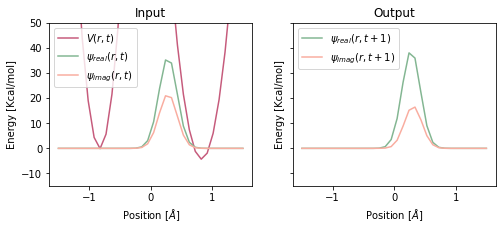

In [13]:
r_n = torch.linspace(-1.5,1.5,32)
time = int(0)  # from 0 to 199

In_real_vis = X_vis[time,0:n_grid]
In_imag_vis = X_vis[time,n_grid:n_grid*2]
In_pote = X_vis[time,n_grid*2:]

Ou_real_vis = y_vis[time,0:n_grid]
Ou_imag_vis = y_vis[time,n_grid:n_grid*2]


fig, axs = plt.subplots(1,2)


# Lenght: au -> Angstroms & au -> kcal/mol
axs[0].plot(r_n, In_pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0].plot(r_n, In_real_vis*30, label="$\psi_{real}(r, t)$", color = color[0])  # Escaled
axs[0].plot(r_n, In_imag_vis*30, label="$\psi_{imag}(r, t)$", color=color[1])  # Escaled
axs[0].set_title("Input")

axs[1].plot(r_n, (In_real_vis + Ou_real_vis)*30, label="$\psi_{real}(r, t+1)$", color = color[0])  # Escaled
axs[1].plot(r_n, (In_imag_vis + Ou_imag_vis)*30, label="$\psi_{imag}(r, t+1)$", color = color[1])  # Escaled
axs[1].set_title("Output")


for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-15, 50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')

plt.gcf().set_size_inches(8, 3)
ax.legend()
plt.show()

## LSTM model
___

In [14]:
print(torch.__version__)

1.9.0+cu102


In [15]:
device = 'cpu'

In [16]:
class LSTM(nn.Module):
    def __init__(self, num_output, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_output = num_output  # number of output
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True).to(device) #lstm
        
        #self.fc_1 =  nn.Linear(hidden_size, 1024) #fully connected 1

        #self.relu = nn.ReLU()
        
        self.fc = nn.Linear(hidden_size, num_output).to(device) #fully connected last layer
    
    def forward(self,x):
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1,self.hidden_size) #reshaping the data for Dense layer next
        #out = self.relu(hn)
        #out = self.fc_1(out) #first Dense
        #out = self.relu(output) #relu
        out = self.fc(output) #Final Output
        return out

In [17]:
input_size = n_grid*3  # number of features: 32 real part +32 complex part +32 potential
hidden_size = 1024  # number of features in hidden state
num_layers = 2  # number of stacked lstm layers
num_output = n_grid*2  # number of output: 32 real part + 32 complex part
sequence_len = seq_len # lenght of time steps (1 fs each one) total 5 fs

In [18]:
model = LSTM(num_output, input_size, hidden_size, num_layers, sequence_len) #our lstm class

In [19]:
# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  #weight_decay=0.01 <- default

In [20]:
#model = torch.load('../../src/Models/06-08-23_290EPOCHS.pth')

In [21]:
print(model)

LSTM(
  (lstm): LSTM(96, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
)


## Accuracy function

In [22]:
def S_overlap(Psi_true, Psi_ANN, X):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test, Shape: (batch size, sequence lenght, 64)
    Psi_ANN: Evolution of wavepacket predicted with the model, Shape: (batch size, sequence lenght, 64)
    X : Evolution of wavepacket at time t-1
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article

    """
    
    Psi_true_re = Psi_true[:,:,0:n_grid] + X[:,:,0:n_grid]   # realpart of wavepacket predicted
    Psi_true_im = Psi_true[:,:,n_grid:n_grid*2] + X[:,:,n_grid:n_grid*2]  # imaginary part of wavepacket predicted 
    Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1)).to(device)
    
    Psi_ANN_re = Psi_ANN[:,:,0:n_grid]+ X[:,:,0:n_grid]  # realpart of wavepacket predicted
    Psi_ANN_im = -(Psi_ANN[:,:,n_grid:n_grid*2]+ X[:,:,n_grid:n_grid*2])  # imaginary part of wavepacket predicted (- because conjugate)
    Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1)).to(device)
    
    overl = Psi_A*Psi_t
    
    # Integrate over r (real integral + complex integral)
    # Trapezoid method in the grid r_n (angstroms -> au)
    
    r_n = (torch.linspace(-1.5,1.5,32)*(1/0.5291775)).to(device)
    overl_real = overl.real
    overl_imag = overl.imag
    
    real_integ = torch.trapz(overl_real, r_n).to(device)
    imag_integ = torch.trapz(overl_imag, r_n).to(device)
    
    # Covert to phase and magnitude of the complex result
    S =  torch.sqrt(real_integ**2 + imag_integ**2).to(device)
    angle = torch.arctan(imag_integ/real_integ).to(device)
    
    # Mean S & angle
    S = torch.sum(S)/(batch_size*seq_len)
    angle = torch.sum(angle)/(batch_size*seq_len)
    
    
    return S, angle

In [57]:
%%time
# Test over test loader
correct1 = 0
correct2 = 0
for X, y in test_loader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    X, y = X.to(device), y.to(device)
    S, angle = S_overlap(y, y, X)  # Accuracy by equation (11) Main Article       
    correct1 += S
    correct2 += angle
correct1 /= len(test_loader)
correct2 /= len(test_loader)
print(f"Test Error: \n Accuracy: {(100*correct1):>0.1f}%\n")# Should be 100% because y=y => main of |S| = 1
print(f"Test Error: \n Accuracy: {(correct2):>0.1f}%\n")# Should be 0

Test Error: 
 Accuracy: 100.0%

Test Error: 
 Accuracy: 0.0%

CPU times: user 3.02 s, sys: 50.3 ms, total: 3.07 s
Wall time: 845 ms


In [60]:
writer = SummaryWriter(comment="trash")  # To use tensorboard

In [61]:
for X,y in train_loader:
    writer.add_graph(model,X)  # to draw diagram model
    break

## Train & Test loop definition

In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)#len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.squeeze().to(device)

        # Compute prediction error
        pred = model(X.float()).squeeze()
        loss = loss_fn(pred, y.float())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    writer.add_scalar("Loss/train", loss, epoch)


In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y, pred,X)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches
    test_loss /= num_batches
    
    writer.add_scalar('Accuracy Magnitude |S| /test', 100*correctS, epoch)  # Should be 100%
    writer.add_scalar('Accuracy phase /test', correct_phase, epoch)  # Should be 0
    writer.add_scalar("Loss/validation", test_loss, epoch)

    

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

## Training

In [64]:
%%time
epochs = 1
for epoch in range(0,epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, criterion, optimizer)
    test(val_loader, model, criterion)
    
writer.flush()

Epoch 1
-------------------------------
loss: 0.108901  [    0/  560]
loss: 0.107287  [  100/  560]
loss: 0.071403  [  200/  560]
loss: 0.068194  [  300/  560]
loss: 0.065636  [  400/  560]
loss: 0.056550  [  500/  560]
Test Error: 
 Accuracy Magnitude |S|: 36.4%
Test Error: 
 Accuracy phase: -0.1

CPU times: user 2h 15min 1s, sys: 12.2 s, total: 2h 15min 13s
Wall time: 34min


In [ ]:
#torch.save(model, '../../Models/06-08-23_290EPOCHS.pth')

In [ ]:
# Initialize the loss function and optimizer
#criterion = nn.MSELoss().to(device)
##optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  #weight_decay=0.01 <- default

## Accuracy Test New Data

In [25]:
def test1(dataloader, model, loss_fn):
    '''
    Same as test function but without writer to tensorboard
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correctS, correct_phase = 0, 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y,pred)  
            correctS += S
            correct_phase += angle
    
    correctS /= num_batches
    correct_phase /= num_batches

    print(f"Test Error: \n Accuracy Magnitude |S|: {(100*correctS):>0.1f}%")
    print(f"Test Error: \n Accuracy phase: {(correct_phase):>0.1f}\n")

In [ ]:
test1(test_loader, model2, criterion)

|Model Name: 06-08-23_--EPOCHS.pth|
|--- |

|Epoch | Accuracy Magnitude | Accuracy phase |
| --- | --- | --- |
|220 | 94.1%| 0.0015 |
|240 | 94.3%| -0.014 |
|260 | 94.4%| -0.003 |
|290 | 94.6%| 0.0001|

In [26]:
model = torch.load('../Models/06-08-23_290EPOCHS.pth')

FileNotFoundError: [Errno 2] No such file or directory: '../Models/06-08-23_290EPOCHS.pth'

## Predictions wavepackets

In [ ]:
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y

    with torch.inference_mode():
        Prediccion = model(X.float())
    break

In [ ]:
print(Entrada.shape)
print(Prediccion.shape)
print(Salida.shape)

In [ ]:
r_n = np.linspace(-1.5,1.5,32)

time = int(105)

In_real_vis = Entrada[2,time,0:32].detach().numpy()
In_imag_vis = Entrada[2,time,32:64].detach().numpy()
Pote = Entrada[2,time,64:96].detach().numpy()

Ou_real_vis = Salida[2,time,0:32].detach().numpy()
Ou_imag_vis = Salida[2,time,32:64].detach().numpy()
Pote_next = Entrada[2,time+1,64:96].detach().numpy()

Pred_real_vis = Prediccion[2,time,0:32].detach().numpy()
Pred_imag_vis = Prediccion[2,time,32:64].detach().numpy()

In [ ]:
fig, axs = plt.subplots(2,2)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,0].plot(r_n, In_real_vis*20, label="$\psi_{real}(r, t)$", color=color[0])  # Escaled


axs[0,1].plot(r_n, Pote*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
axs[0,1].plot(r_n, In_imag_vis*20, label="$\psi_{imag}(r, t)$", color =color[1])  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, Ou_real_vis*20, label="$\psi_{real}(r, t+1)_{True}$", color=color[0])  # Escaled
axs[1,0].scatter(r_n, Pred_real_vis*20, label="$\psi_{real}(r, t+1)_{LSTM}$", color=color[4], marker='.')  # Escaled
 

axs[1,1].plot(r_n, Ou_imag_vis*20, label="$\psi_{imag}(r, t+1)_{True}$", color =color[1])  # Escaled
axs[1,1].scatter(r_n, Pred_imag_vis*20, label="$\psi_{imag}(r, t+1)_{LSTM}$", color =color[4], marker='.')  # Escaled


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_ylim([-35,50])
    ax.legend()
    ax.set(xlabel='Position [$\AA$]')
    ax.label_outer()
 

plt.gcf().set_size_inches(8, 5.33)
plt.legend()    
plt.show()
plt.savefig('/home/jessica/Tesis/img/tesis/model/1step4.png', dpi=700)


## Predictions density

In [ ]:
for X,y in test_loader:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y

    with torch.inference_mode():
        Prediccion = model(X.float())
    break

In [ ]:
#------------- t=0
In_real_vis0 = Entrada[2,0,0:32].detach().numpy()
In_imag_vis0 = Entrada[2,0,32:64].detach().numpy()
In_dens0 = (np.abs(np.vectorize(complex)(In_real_vis0,In_imag_vis0)))**2

Pote0 = Entrada[2,0,64:96].detach().numpy()


#------------ t=40 fs
Ou_real_vis0 = Salida[2,40,0:32].detach().numpy()
Ou_imag_vis0 = Salida[2,40,32:64].detach().numpy()
Ou_dens0 = (np.abs(np.vectorize(complex)(Ou_real_vis0,Ou_imag_vis0)))**2
      
Pred_real_vis0 = Prediccion[2,40,0:32].detach().numpy()
Pred_imag_vis0 = Prediccion[2,40,32:64].detach().numpy()
Pred_dens0 = (np.abs(np.vectorize(complex)(Pred_real_vis0,Pred_imag_vis0)))**2

#-------------- t=80 fs
In_real_vis1 = Entrada[2,80,0:32].detach().numpy()
In_imag_vis1 = Entrada[2,80,32:64].detach().numpy()
Pote1 = Entrada[2,80,64:96].detach().numpy()

Ou_real_vis1 = Salida[2,80,0:32].detach().numpy()
Ou_imag_vis1 = Salida[2,80,32:64].detach().numpy()
Ou_dens1 = (np.abs(np.vectorize(complex)(Ou_real_vis1,Ou_imag_vis1)))**2

Pred_real_vis1 = Prediccion[2,80,0:32].detach().numpy()
Pred_imag_vis1 = Prediccion[2,80,32:64].detach().numpy()
Pred_dens1 = (np.abs(np.vectorize(complex)(Pred_real_vis1,Pred_imag_vis1)))**2

#-------------- t=120 fs
In_real_vis2 = Entrada[2,120,0:32].detach().numpy()
In_imag_vis2 = Entrada[2,120,32:64].detach().numpy()
Pote2 = Entrada[2,120,64:96].detach().numpy()

Ou_real_vis2 = Salida[2,120,0:32].detach().numpy()
Ou_imag_vis2 = Salida[2,120,32:64].detach().numpy()
Ou_dens2 = (np.abs(np.vectorize(complex)(Ou_real_vis2,Ou_imag_vis2)))**2

Pred_real_vis2 = Prediccion[2,120,0:32].detach().numpy()
Pred_imag_vis2 = Prediccion[2,120,32:64].detach().numpy()
Pred_dens2 = (np.abs(np.vectorize(complex)(Pred_real_vis2,Pred_imag_vis2)))**2

#-------------- t=160 fs
In_real_vis3 = Entrada[2,160,0:32].detach().numpy()
In_imag_vis3 = Entrada[2,160,32:64].detach().numpy()
Pote3 = Entrada[2,160,64:96].detach().numpy()

Ou_real_vis3 = Salida[2,160,0:32].detach().numpy()
Ou_imag_vis3 = Salida[2,160,32:64].detach().numpy()
Ou_dens3 = (np.abs(np.vectorize(complex)(Ou_real_vis3,Ou_imag_vis3)))**2

Pred_real_vis3 = Prediccion[2,160,0:32].detach().numpy()
Pred_imag_vis3 = Prediccion[2,160,32:64].detach().numpy()
Pred_dens3 = (np.abs(np.vectorize(complex)(Pred_real_vis3,Pred_imag_vis3)))**2

#-------------- t=200 fs
In_real_vis4 = Entrada[2,199,0:32].detach().numpy()
In_imag_vis4 = Entrada[2,199,32:64].detach().numpy()
Pote4 = Entrada[2,199,64:96].detach().numpy()

Ou_real_vis4 = Salida[2,199,0:32].detach().numpy()
Ou_imag_vis4 = Salida[2,199,32:64].detach().numpy()
Ou_dens4 = (np.abs(np.vectorize(complex)(Ou_real_vis4,Ou_imag_vis4)))**2

Pred_real_vis4 = Prediccion[2,199,0:32].detach().numpy()
Pred_imag_vis4 = Prediccion[2,199,32:64].detach().numpy()
Pred_dens4 = (np.abs(np.vectorize(complex)(Pred_real_vis4,Pred_imag_vis4)))**2



In [ ]:
fig, ax = plt.subplots(3,2)

    
# Time: fs -> au, Lenght: au -> Angstroms, Energy: au -> kcal/mol
ax[0,0].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,0].plot(r_n, In_dens0*10, label="$|\psi_{initial}|^{2}$")
ax[0,0].set_title("$t=0 fs$")



ax[0,1].plot(r_n, Pote0*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[0,1].scatter(r_n, Pred_dens0*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[0,1].plot(r_n, Ou_dens0*10, label="$|\psi_{True}|^{2}$")
ax[0,1].set_title("$t=40 fs$")

ax[1,0].plot(r_n, Pote1*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,0].scatter(r_n, Pred_dens1*10, label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,0].plot(r_n, Ou_dens1*10, label="$|\psi_{True}|^{2}$")
ax[1,0].set_title("$t=80 fs$")

ax[1,1].plot(r_n, Pote2*(1/1.5936e-3), "-", label="$V(r, t)$", color=color[3])
ax[1,1].scatter(r_n, Pred_dens2*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[1,1].plot(r_n, Ou_dens2*10, label="$|\psi_{True}|^{2}$")
ax[1,1].set_title("$t=120 fs$")

ax[2,0].plot(r_n, Pote3*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,0].scatter(r_n, Pred_dens3*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,0].plot(r_n, Ou_dens3*10, label="$|\psi_{True}|^{2}$")
ax[2,0].set_title("$t=160 fs$")

ax[2,1].plot(r_n, Pote4*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
ax[2,1].scatter(r_n, Pred_dens4*(10), label="$|\psi_{LSTM}|^{2}$", color=color[4], marker='.')
ax[2,1].plot(r_n, Ou_dens4*10, label="$|\psi_{True}|^{2}$")
ax[2,1].set_title("$t=200 fs$")







for axr1 in ax:
    for axr11 in axr1:
        axr11.set_ylim([-5, 50])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]')
        
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in ax.flat:
    ax.label_outer()
    
    
plt.gcf().set_size_inches(8, 10)
#plt.legend()    
plt.show()
#plt.savefig('/home/jessica/Tesis/img/tesis/model/trajDens11.png', dpi=700)

### Saving data to animation

 #### Inf about X,y predictions
 
 `Entrada[no. batch: from 0 to 9, time: from 0 to 200,(real part, imag part, potential)]`  
 `Salida[no. batch: from 0 to 9, time: from 0 to 200,(real part, imag part)]`  
 `Prediccion[no. batch: from 0 to 9, time: from 0 to 200,(real part, imag part)]`  

#### Torch to numpy

In [ ]:
newPred = Prediccion.numpy()  # By model real & imag part
newSal = Salida.numpy()  # Analitical real & imag part
Poten = Entrada[:,:,64:96].numpy()  # Potential

In [ ]:
anim_path = '../Animacion/ModelLSTM-32size'  # animation data file

In [ ]:
with open(os.path.join(anim_path+'/prediccion.npy'), 'wb') as f:
    np.save(f, newPred)

In [ ]:
with open(os.path.join(anim_path+'/salida.npy'), 'wb') as f:
    np.save(f, newSal)

In [ ]:
with open(os.path.join(anim_path+'/potencial.npy'), 'wb') as f:
    np.save(f, Poten)

### Saving data to animation for animation python file 

In [31]:
# To save data in a file
directory = '../Predictions/'
# Creating the file
h5f = h5py.File(directory+time.strftime("%Y%m%d-%H%M%S")+'.h5', 'w')

In [ ]:
# Saving X data
h5f.create_dataset('dataset_X', data=Entrada)
# Saving y data
h5f.create_dataset('dataset_y', data=Salida)
h5f.create_dataset('dataset_p', data=Prediccion)

## New trajectory

Para asegurar que la red funciona xd

In [ ]:
path_test = '../../NewTrajectories/data'  # Directory where are a total new trajectory
seq_len = 200  # How many time stamps

In [ ]:
dataset_newTest = Propagator_Dataset(data=path_test, targets=path_test, transform=True, sequence_len=seq_len, total_data = 1*200)

In [ ]:
newTraj = DataLoader(dataset_newTest)

In [ ]:
for X,y in newTraj:
    X, y = X.to(device), y.to(device)
    
    Entrada = X
    
    Salida = y
    with torch.inference_mode():
        Prediccion = model(X.float())
    break

In [ ]:
print(Entrada.shape)
print(Prediccion.shape)
print(Salida.shape)

In [ ]:
r_n = np.linspace(-1.5,1.5,32)

time = int(60)  # from 0 to 199 fs

In_real_vis = Entrada[0,time,0:32].detach().numpy()
In_imag_vis = Entrada[0,time,32:64].detach().numpy()
Pote = Entrada[0,time,64:96].detach().numpy()

Ou_real_vis = Salida[0,time,0:32].detach().numpy()
Ou_imag_vis = Salida[0,time,32:64].detach().numpy()
Pote_next = Entrada[0,time+1,64:96].detach().numpy()

Pred_real_vis = Prediccion[0,time,0:32].detach().numpy()
Pred_imag_vis = Prediccion[0,time,32:64].detach().numpy()

In [ ]:
fig, axs = plt.subplots(2,2)

# Lenght: au -> Angstroms
axs[0,0].plot(r_n, Pote*(1/1.5936e-3), "-", label="V(r,t)")
axs[0,0].plot(r_n, In_real_vis*20, label="$\psi_{r}(r, t)$")  # Escaled


axs[0,1].plot(r_n, Pote*(1/1.5936e-3), "-", label="V(r,t)")
axs[0,1].plot(r_n, In_imag_vis*20, label="$\psi_{i}(r, t)$")  # Escaled

#axs[0].plot(r_n, Pote_next*(1/1.5936e-3), "-", label="V(r,t)", color=color[3])
axs[1,0].plot(r_n, Ou_real_vis*20, label="$\psi_{r}(r, t+1)_{True}$")  # Escaled
axs[1,0].scatter(r_n, Pred_real_vis*20, label="$\psi_{r}(r, t+1)_{LSTM}$", marker='.')  # Escaled


axs[1,1].plot(r_n, Ou_imag_vis*20, label="$\psi_{i}(r, t+1)_{True}$")  # Escaled
axs[1,1].scatter(r_n, Pred_imag_vis*20, label="$\psi_{i}(r, t+1)_{LSTM}$", marker='.')  # Escaled

for axr1 in axs:
    for axr11 in axr1:
        axr11.set_ylim([-20, 60])
        axr11.legend()
        axr11.set(xlabel='Position [$\AA$]', ylabel='Energy [Kcal/mol]')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.gcf().set_size_inches(9, 5)
plt.legend()    
plt.show()

yes it works

## Loss and S
___

In [ ]:
import csv

fileS1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06.csv'
fileS2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-S.csv.csv'

fileT1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06-tetha.csv'
fileT2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-tetha.csv'

fileLTra1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06-lossTrain.csv'
fileLTra2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-lossTrain.csv'

fileLTe1 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug06-lossTest.csv'
fileLTe2 = '../runs/Aug06_16-54-53_Aldos-MBP.fritz.boxUpdate2LSTM_1024neu_seq200_BATCH_10_LR_1E-4_4700DATA/Aug12-lossTest.csv'






In [ ]:
import pandas as pd
#headers = ['Wall time', 'Step', 'Value']

dfS1 = pd.read_csv(fileS1)
dfS2 = pd.read_csv(fileS2)

dfT1 = pd.read_csv(fileT1)
dfT2 = pd.read_csv(fileT2)

dfLTra1 = pd.read_csv(fileLTra1)
dfLTra2 = pd.read_csv(fileLTra2)

dfLTe1 = pd.read_csv(fileLTe1)
dfLTe2 = pd.read_csv(fileLTe2)


In [ ]:
dfS = pd.concat([dfS1, dfS2], ignore_index=True, sort=False)
dfth = pd.concat([dfT1, dfT2], ignore_index=True, sort=False)
dfLTra = pd.concat([dfLTra1, dfLTra2], ignore_index=True, sort=False)
dfLTe = pd.concat([dfLTe1, dfLTe2], ignore_index=True, sort=False)

In [ ]:
dfS.tail

In [ ]:
#dfS.plot(x = 'Step', y = 'Value')
fig, ax = plt.subplots(1,2)

ax[0].plot(dfS["Step"], dfS["Value"]*0.01, color=color[2])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Absolute Magnitude $|S|$')

ax[1].plot(dfS["Step"], dfth["Value"], color=color[2])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel(r'Phase $\theta$')


plt.gcf().set_size_inches(11, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/S-plot.png', dpi=700)
plt.show()

In [ ]:
def my_tb_smooth(scalars: list[float], weight: float) -> list[float]:  # Weight between 0 and 1
    """

    ref: https://stackoverflow.com/questions/42011419/is-it-possible-to-call-tensorboard-smooth-function-manually

    :param scalars:
    :param weight:
    :return:
    """
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed: list = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

In [ ]:
anu = my_tb_smooth(dfLTra["Value"], 0.9)

In [ ]:
fig, ax = plt.subplots()

ax.plot(dfS["Step"], anu, color=color[2], label='Train')
ax.plot(dfS["Step"], dfLTe["Value"], color=color[4], label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')



plt.legend()
plt.gcf().set_size_inches(6, 4)
plt.savefig('/home/jessica/Tesis/img/tesis/Loss-plot.png', dpi=700)
plt.show()